In [0]:
%matplotlib inline
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.model_selection as model_selection
import time
import random

In [0]:
(x_train, y_train), (x_test_general, y_test_general) = tf.keras.datasets.cifar10.load_data()

readable_labels = ["Plane",
                   "Car",
                   "Bird",
                   "Cat",
                   "Deer",
                   "Dog",
                   "Frog",
                   "Horse",
                   "Ship",
                   "Truck"]

# Normalize input data
x_train, x_test_general = x_train/255.0, x_test_general/255.0

# Partition Test into Validation and Test sets

# 80% of the whole test set will go to be the validation test and 20%
#  will be the actual test set
x_val, x_test, y_val, y_test = model_selection.train_test_split(x_test_general,
                                                                y_test_general,
                                                                train_size=0.80,
                                                                test_size=0.20)


# One-hot encode the training, validation and test classes
y_one_hot_train = tf.keras.utils.to_categorical(y_train)
y_one_hot_val = tf.keras.utils.to_categorical(y_val)
y_one_hot_test = tf.keras.utils.to_categorical(y_test)

In [0]:
# First map all images to its classes to be able to pick one sample of each easily
#  this map will allow us with point 4 where we need to know how many pictures
#  are for each class.
def map_images_to_classes(images: list, labels: list) -> dict:
    images_by_class = {}
    
    for idx, image in enumerate(images):
        # The class is stored in a 1-D NpArray, so we need to unpack the value
        class_id = labels[idx][0]
        
        if class_id not in images_by_class:
            images_by_class[class_id] = [image]
        else:
            images_by_class[class_id].append(image)
    
    return images_by_class

# Use the original 0-9 classes instead of the one-hot encoding
training_images_by_class = map_images_to_classes(x_train, y_train)
validation_images_by_class = map_images_to_classes(x_val, y_val)
test_images_by_class = map_images_to_classes(x_test, y_test)

In [0]:
def compile_sgd_optimizer(model_to_fit: tf.python.keras.engine.training.Model,
                          epochs: int,
                          batch: int,
                          learning_rate: float,
                          momentum: float,
                          use_nesterov: bool = True) -> tf.python.keras.engine.training.Model:
    
    optimizer = tf.keras.optimizers.SGD(lr=learning_rate,
                                    decay=learning_rate / epochs,
                                    momentum=momentum,
                                    nesterov=use_nesterov)

    model_to_fit.compile(optimizer=optimizer,
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
    return model_to_fit


def train_model(model_to_fit: tf.python.keras.engine.training.Model,
                epochs: int,
                batch: int,
                train_data: tuple,
                validation_data: tuple,
                callbacks: list = None):

    t = time.process_time()
    
    trained_model = model_to_fit.fit(train_data[0],
                                     train_data[1],
                                     validation_data=validation_data,
                                     epochs=epochs,
                                     batch_size=batch,
                                     callbacks=callbacks)
    
    elapsed_time = time.process_time() - t
    
    print(f"\n\n ********* Training time: {elapsed_time} s.")
    return trained_model

def graph_loss_accuracy(h_model,
                        epochs: int,
                        subtitle: str = ""):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0,epochs),h_model.history["accuracy"],label="train_acc")
    plt.plot(np.arange(0,epochs),h_model.history["val_accuracy"],label="val_acc")
    plt.title("Training and Validation Accuracy" 
              + f" ({subtitle})" if subtitle else "")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.figure()
    plt.plot(np.arange(0,epochs),h_model.history["loss"],label="train_loss") 
    plt.plot(np.arange(0,epochs),h_model.history["val_loss"],label="val_loss")
    plt.title("Training and Validation Loss" 
              + f" ({subtitle})" if subtitle else "")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

# Helper functions for reporting

def print_dataset_prediction_report(predictions,
                                    dataset_tuple: tuple,
                                    human_readable_labels: list,
                                    dataset_title: str):
    # For classification_report the one_hot_encoding test labels are needed,
    #  these are passed in the validation_tuple[1] and test_tuple[1]
    print(f"\n\nClassification Report - {dataset_title}:")
    print(classification_report(dataset_tuple[1].argmax(axis=1), 
                            predictions.argmax(axis=1),
                            target_names=human_readable_labels))
    
    print(f"\n\nConfusion Matrix: - {dataset_title}:")
    print(confusion_matrix(dataset_tuple[1].argmax(axis=1),
                           predictions.argmax(axis=1)))

In [0]:
def print_error_samples(test_tuple, test_predictions):
    print("\n\nError Samples\n")
    incorrect_samples_by_label = {}

    indices = [i for i,v in enumerate(test_predictions) 
                if test_predictions[i] != test_tuple[1][i]]
    subset_of_wrongly_predicted = [test_tuple[0][i] for i in indices ]
    print(f"Wrong predictions: \n {subset_of_wrongly_predicted}")

    print(test_predictions)
    
    # Focus only on those samples that were incorrect
    for idx, real_label in enumerate(test_tuple[1]):
        predicted_label = test_predictions[idx]

        print(predicted_label)
        print(test_predictions[idx])

        if real_label != predicted_label:

            incorrect_sample = (test_tuple[0], real_label, predicted_label)

            if real_label not in incorrect_samples_by_label:
                incorrect_samples_by_label[real_label] = [incorrect_sample]
            else:
                incorrect_samples_by_label[real_label].append(incorrect_sample)
    
    top_3 = incorrect_samples_by_label.values()
    top_3.sort(key=len, reverse=True)

    sample_fig = plt.figure(figsize=(3, 12))
    plt.title("Error samples")

    rows = 10
    columns = 3

    plot_position = 0

    for incorrect_samples in top_3[:3]:
        #training_image = random.choice(training_images_by_class[class_num])
        #val_image = random.choice(validation_images_by_class[class_num])
        #test_image = random.choice(test_images_by_class[class_num])

        plot_position += 1
        sample_fig.add_subplot(rows, columns, plot_position)
        plt.imshow(random.choice(incorrect_samples)[0])

        plot_position += 1
        sample_fig.add_subplot(rows, columns, plot_position)
        plt.imshow(random.choice(incorrect_samples)[0])

        plot_position += 1
        sample_fig.add_subplot(rows, columns, plot_position)
        plt.imshow(random.choice(incorrect_samples)[0])

In [0]:
def evaluate_model(model_to_fit: tf.python.keras.engine.training.Model,
                   epochs: int,
                   batch: int,
                   learning_rate: float,
                   momentum: float,
                   train_tuple: tuple,
                   validation_tuple: tuple,
                   test_tuple: tuple,
                   labels: list,
                   use_nesterov: bool = True,
                   callbacks: list = None,
                   should_print_test_error_samples: bool = False):
    
    subtitle = f"Epochs: {epochs} Batch: {batch} LR: {learning_rate}"

    model_to_fit = compile_sgd_optimizer(model_to_fit,
                               epochs,
                               batch,
                               learning_rate,
                               momentum,
                               use_nesterov)

    trained_model_history = train_model(model_to_fit,
                                epochs,
                                batch,
                                train_tuple,
                                validation_tuple,
                                callbacks=callbacks)
                                    
    model_to_fit.summary()

    print("\n\n ****** Validation Dataset Prediction Report ******")
    val_model_predictions = model_to_fit.predict(validation_tuple[0],
                                                 batch_size=batch)
    
    #print_dataset_prediction_report(val_model_predictions,
    #                                validation_tuple,
    #                                labels,
    #                                "Validation Dataset")


    print("\n\n ****** Test Dataset Prediction Report ******")

    # Use the test_tuple for predictions instead of the validation
    #  The test images are in the first position of the test_tuple
    test_model_predictions = model_to_fit.predict(test_tuple[0], batch_size=batch)
    
    #print_dataset_prediction_report(test_model_predictions,
    #                                test_tuple,
    #                                labels,
    #                                "Test Dataset")
    
    if should_print_test_error_samples:
        print_error_samples(test_tuple, test_model_predictions)
    
    graph_loss_accuracy(trained_model_history, epochs=epochs, subtitle=subtitle)
    
    return model_to_fit, trained_model_history, val_model_predictions, test_model_predictions

In [0]:
vgg_model = tf.keras.models.Sequential([
   
   # ------- C1 Block 1-------:
   tf.keras.layers.Conv2D(input_shape=(32,32,3),
                          filters=32,
                          kernel_size=3,
                          strides=(1,1),
                          padding='same',
                          activation='relu'),

   tf.keras.layers.BatchNormalization(axis=-1),

   tf.keras.layers.Conv2D(filters=32,
                          kernel_size=3,
                          strides=(1,1),
                          padding='same',
                          activation='relu'),

   tf.keras.layers.BatchNormalization(axis=-1),
  
   #Pooling layer for C1:
   tf.keras.layers.MaxPooling2D(pool_size=(2,2),
                                strides=(2,2)),

   # Dropout
   tf.keras.layers.Dropout(0.25),
   
   # ------- C2 Block 2 -------:
   tf.keras.layers.Conv2D(filters=64,
                          kernel_size=3,
                          strides=(1,1),
                          padding='same',
                          activation='relu'),

   tf.keras.layers.BatchNormalization(axis=-1),

   tf.keras.layers.Conv2D(filters=64,
                          kernel_size=3,
                          strides=(1,1),
                          padding='same',
                          activation='relu'),

   tf.keras.layers.BatchNormalization(axis=-1),
  
   #Pooling layer for C1:
   tf.keras.layers.MaxPooling2D(pool_size=(2,2),
                                strides=(2,2)),

   # Dropout
   tf.keras.layers.Dropout(0.25),

   # ------- Dense layers -------:

   tf.keras.layers.Flatten(),

   tf.keras.layers.Dense(512,
                         activation='relu'),

   #tf.keras.layers.BatchNormalization(axis=-1),

   # Dropout
   tf.keras.layers.Dropout(0.5),

   #Output   
   tf.keras.layers.Dense(10,
                         activation=tf.nn.softmax)
   ])

Epoch 1/3
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6901 - accuracy: 0.4068 - val_loss: 1.3168 - val_accuracy: 0.5221
Epoch 2/3
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3424 - accuracy: 0.5164 - val_loss: 1.1549 - val_accuracy: 0.5846
Epoch 3/3
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2406 - accuracy: 0.5560 - val_loss: 1.0722 - val_accuracy: 0.6204


 ********* Training time: 29.68701769900001 s.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
______________________________________

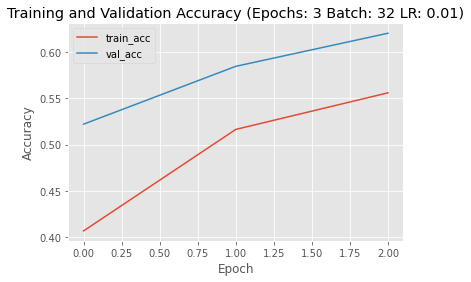

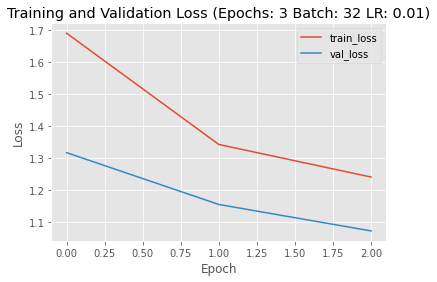

In [17]:
model, history, val_pred, test_pred = evaluate_model(vgg_model,
               epochs=3,
               batch=32,
               learning_rate=0.01,
               momentum=0.9,
               train_tuple=(x_train, y_one_hot_train),
               validation_tuple=(x_val, y_one_hot_val),
               test_tuple=(x_test, y_one_hot_test),
               labels=readable_labels,
               use_nesterov = True,
               should_print_test_error_samples=False)

In [24]:
# Get wrong Records
rounded_val_prediction = np.round(val_pred)
print(val_pred)
print(rounded_val_prediction)

indices = [i for i, pred_encoding in enumerate(rounded_val_prediction) 
           if not (pred_encoding == y_one_hot_val[i]).all()]
subset_of_wrongly_predicted = [x_val[i] for i in indices]

print(f"Len of indices of wrong: {len(indices)}")
print(f"Len of indices of wrong: {len(subset_of_wrongly_predicted)}")
print(f"Out of {len(val_pred)} records")
print(f"Accuracy: {len(indices)/len(val_pred)}")

# Choose 3 random elements:
random.sample(the_list, 50)

print("Done!")



[[5.90701879e-04 6.10863299e-06 2.43715569e-03 ... 9.19333637e-01
  1.14568329e-05 2.84868875e-04]
 [1.07837440e-02 9.84858442e-03 6.93280101e-02 ... 8.20270553e-02
  1.64658390e-02 1.35666013e-01]
 [3.68788186e-03 4.13011760e-04 1.18951514e-01 ... 8.03155452e-02
  2.85745156e-03 1.13476033e-03]
 ...
 [4.76544490e-03 1.30846433e-03 3.45522054e-02 ... 4.88631904e-01
  2.66698858e-04 3.85471014e-03]
 [5.17182238e-02 5.25681477e-04 2.77059706e-04 ... 1.96428672e-07
  9.47377086e-01 6.61080630e-05]
 [9.52785555e-03 4.77166194e-03 2.56213248e-01 ... 7.69823790e-02
  7.65248202e-03 8.22384283e-03]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Len of indices of wrong: 4467
Len of indices of wrong: 4467
Out of 8000 records
Accuracy: 0.558375
Done!


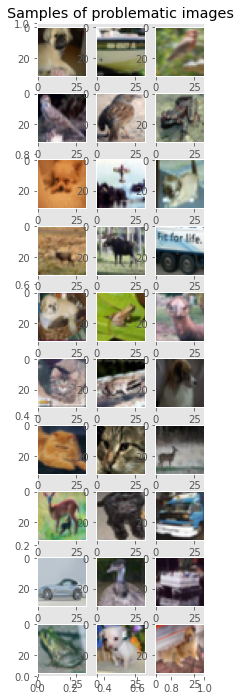

In [33]:
def print_error_samples(dataset_tuple, dataset_predictions):
    dataset_images = dataset_tuple[0]
    y_one_hot_embeddings = dataset_tuple[1]

    # Get wrong Records
    rounded_prediction = np.round(dataset_predictions)

    wrong_indices = [idx for idx, pred_encoding in enumerate(rounded_prediction) 
            if not (pred_encoding == y_one_hot_embeddings[idx]).all()]
    wrongly_predicted_images = [dataset_images[i] for i in wrong_indices]

    # Get some samples:

    wrong_samples = random.sample(wrongly_predicted_images, 30)

    # Draw them

    sample_fig = plt.figure(figsize=(3, 12))
    plt.title("Samples of problematic images")
    plt.rcParams["axes.grid"] = False

    rows = 10
    columns = 3

    plot_position = 0

    for sample in wrong_samples:

        plot_position += 1
        sample_fig.add_subplot(rows, columns, plot_position)
        plt.imshow(sample)

print_error_samples((x_val, y_one_hot_val), val_pred)